# Wrapping ASTRA in a web API and how to use it
Author: Alexander Klemps, alexander.klemps@tuhh.de

In [1]:
%%capture
!pip install --upgrade openpmd-beamphysics vtk pyvista trame trame-vtk trame-vuetify

In [2]:
import requests
import timeit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pyvista as pv
import os

## API request settings

In [3]:
# request URL pointing to locally running service
REQUEST_URL = "http://0.0.0.0:8000/" 
# headers include API key secret for authentication
REQUEST_HEADERS = {'Content-Type': 'application/json', 'x-api-key': os.getenv("ASTRA_API_KEY")}

def request(endpoint, data):
    response = requests.post(REQUEST_URL + endpoint, headers=REQUEST_HEADERS, json=data)
    print(f"Response code {response.status_code}\n")
    return response.json()

## Generate particle distribution by request

Refer to the [API documenation](http://localhost:8000/docs) for a full list and description of input parameters. In the following we will generate a particle distribution based on some input parameters by request to the API. 

In [4]:
generator_parameters = { 
    "particle_count": 10000, 
    "time_spread": False,
    "dist_z": "flattop",
    "flattop_time_length": 3.0*1e-3, # 3ps
    "flattop_rise_time": 0.2*1e-3, # 3ps
    "rms_bunch_size_x":0.34E0,
    "rms_bunch_size_y": 0.34E0,
    "reference_kinetic_energy": 0.55*1e-6,
    "gaussian_cutoff_x": 1.0,
    "gaussian_cutoff_y": 1.0,
    "flattop_z_length": 3.0,
    "flattop_rise_z": 0.02,
    "rms_energy_spread": 1.0019*1e-06,
    "x_emittance": 0.1473,
    "y_emittance": 0.1473
}

response = request("generate", generator_parameters)
print(response['input_ini'])
print(response['run_output'])

Response code 200

&INPUT
    Add = false
    N_add = 0
    IPart = 10000
    Species = 'electrons'
    Probe = true
    Noise_reduc = true
    Cathode = false
    High_res = true
    Q_total = 1.0
    Dist_z = 'plateau'
    Dist_pz = 'gauss'
    Dist_x = 'gauss'
    Dist_px = 'gauss'
    Dist_y = 'gauss'
    Dist_py = 'gauss'
    cor_Ekin = 0.0
    cor_px = 0.0
    cor_py = 0.0
    Ref_Ekin = 5.5e-7
    Ref_zpos = 0.0
    sig_Ekin = 1.0018999999999999e-6
    sig_x = 0.34
    sig_y = 0.34
    sig_z = 0.0
    sig_clock = 0.001
    Nemit_x = 0.1473
    Nemit_y = 0.1473
    C_sig_x = 1.0
    C_sig_y = 1.0
    C_sig_z = 0.0
    Lz = 3.0
    rz = 0.02
    Lt = 0.003
    rt = 0.0002
    FNAME = '/app/data/generator/1707938660.746852.ini'
/
 --------------------------------------------------------------------------

                              generator              
                             Version 1.0             
                        DESY,  Hamburg 2002          
                 

In [5]:
astra_particle_data = pd.DataFrame(response['particles'])
astra_particle_data

,x,y,z,px,py,pz,t_clock,macro_charge,species,status
0,0.000000,0.000000,0.000000,0.000000,0.000000,749.735688,0.0,-0.0001,1,5
1,0.000170,0.000000,0.000433,0.000000,0.000000,0.000000,0.0,-0.0001,1,3
2,0.000000,0.000170,-0.000433,0.000000,0.000000,0.000000,0.0,-0.0001,1,3
3,0.000340,0.000000,0.000866,0.000000,0.000000,0.000000,0.0,-0.0001,1,3
4,0.000000,0.000340,-0.000866,0.000000,0.000000,0.000000,0.0,-0.0001,1,3
...,...,...,...,...,...,...,...,...,...,...
9995,-0.000223,-0.000006,0.000244,414.106214,475.630026,-85.758230,0.0,-0.0001,1,5
9996,-0.000289,-0.000072,-0.000475,268.702767,256.175386,-30.127923,0.0,-0.0001,1,5
9997,0.000339,-0.000141,-0.001075,214.579616,94.235189,-9.194540,0.0,-0.0001,1,5
9998,0.000265,-0.000216,0.001324,108.687788,-53.733797,-0.942954,0.0,-0.0001,1,5


## Analysis of generation output

For analysis and visualization of the generated particle distributions, the package [openPMD-beamphysics](https://github.com/ChristopherMayes/openPMD-beamphysics/tree/571f7e37cdab38a6612ca188a21cc5db3eb774ac) by Christopher Mayes will be used. More information can be found in the corresponding [documentation](https://christophermayes.github.io/openPMD-beamphysics/).

In this framework, the particles are represented as object of type <b>ParticleGroup</b>, which can be instantiated from a distribution generated with ASTRA after applying some transformation to some data fields. All this will be handled by the following function.

In [6]:
from pmd_beamphysics import ParticleGroup

def to_pmd(particles: pd.DataFrame) -> ParticleGroup:
    data = particles.copy()
    ref = data.iloc[0]

    data['weight'] = np.abs(data.pop('macro_charge')) * 1e-9
    data.loc[1:, 'z'] = data.loc[1:, 'z'] + ref['z']
    data.loc[1:, 'pz'] = data.loc[1:, 'pz'] + ref['pz']
    data.loc[1:, 't_clock'] = (data.loc[1:, 't_clock'] + ref['t_clock'])*1e-9
    data.loc[data['status'] == 1, 'status'] = 2
    data.loc[data['status'] == 5, 'status'] = 1
    
    data_dict = data.to_dict('list')
    data_dict['n_particles'] = data.size
    data_dict['species'] = 'electron'
    data_dict['t'] = ref['t_clock']*1e-9

    return ParticleGroup(data=data_dict)

In [7]:
particles = to_pmd(astra_particle_data)
print(particles)

ParticleGroup with 10000 particles with total charge 9.999999999999999e-10 C


### Side views

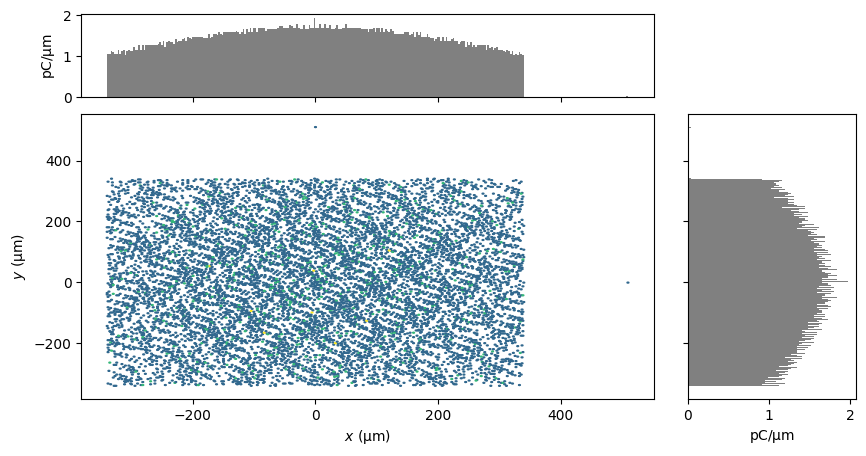

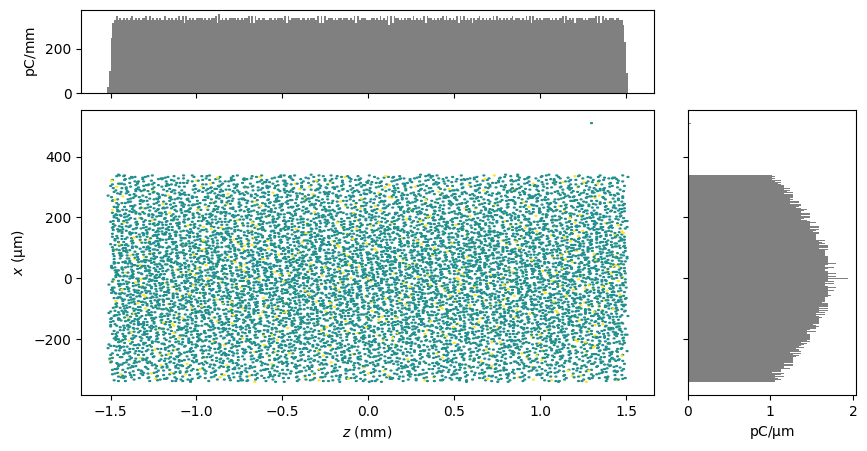

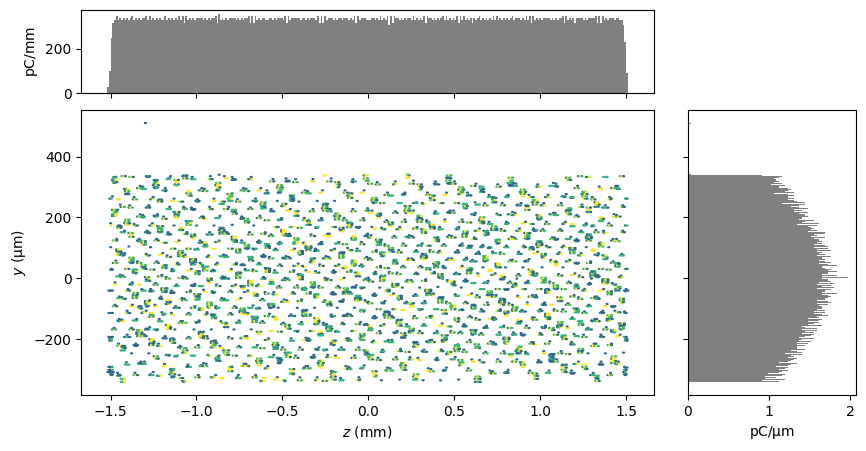

In [8]:
particles.plot('x', 'y', bins=300, figsize=(10, 5))
particles.plot('z', 'x', bins=300, figsize=(10, 5))
particles.plot('z', 'y', bins=300, figsize=(10, 5))

### Phase spaces

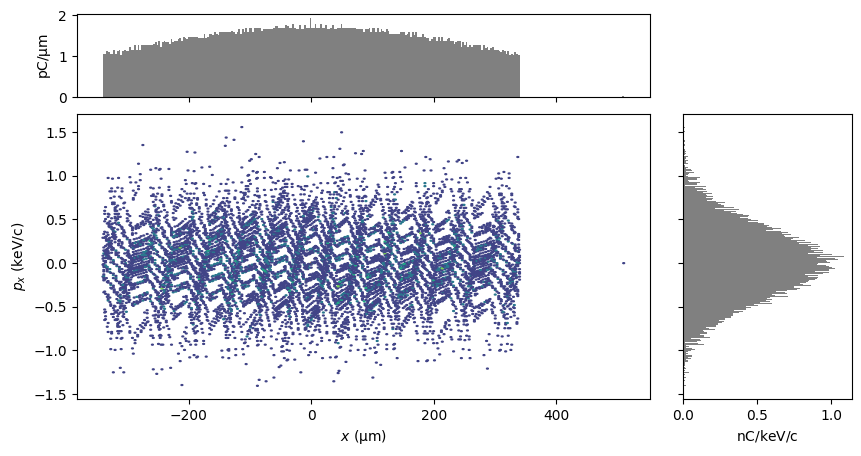

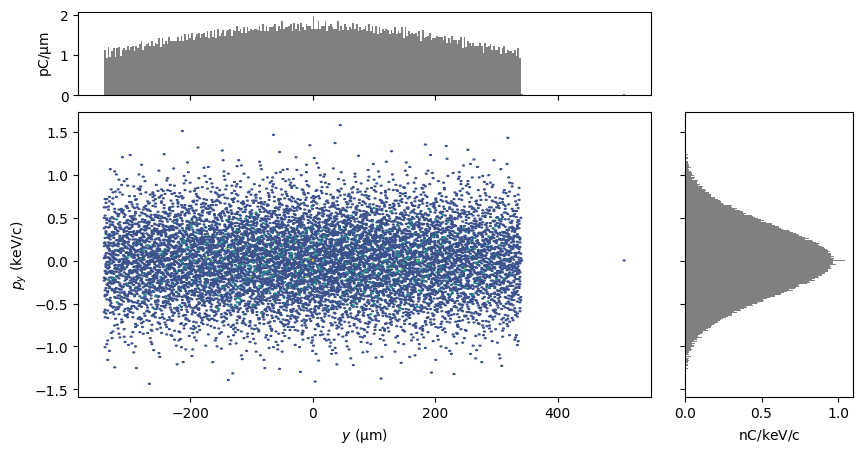

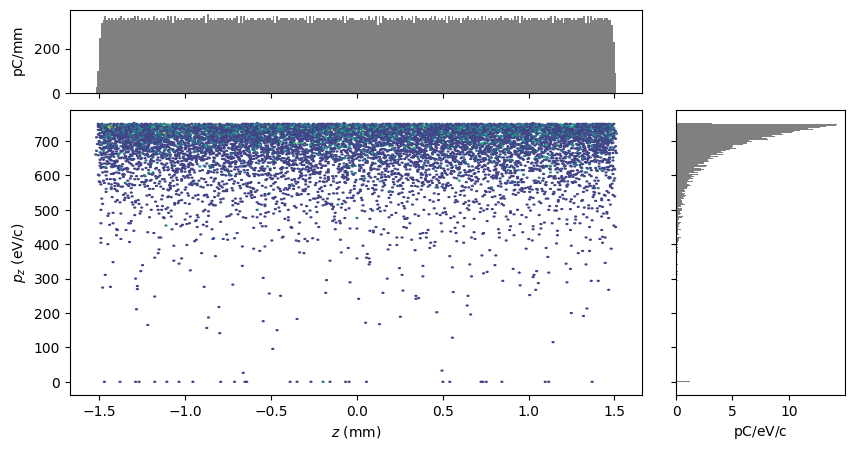

In [9]:
particles.plot('x', 'px', bins=300, figsize=(10, 5))
particles.plot('y', 'py', bins=300, figsize=(10, 5))
particles.plot('z', 'pz', bins=300, figsize=(10, 5))

### Emittance

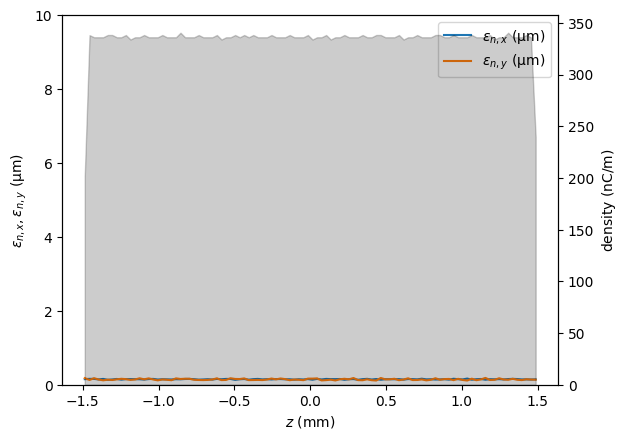

In [10]:
particles.slice_plot('norm_emit_x', 'norm_emit_y', ylim=(0, 1e-5))

## Simulation Request

### Load field tables

In [11]:
cavity_table = pd.read_csv("./data/cavity_E_field.dat", names=['z', 'v'], sep=" ")
bucking_table = pd.read_csv("./data/bucking_B_field.dat", names=['z', 'v'], sep=" ")
main_table = pd.read_csv("./data/main_B_field.dat", names=['z', 'v'], sep=" ")
solenoid_table = pd.read_csv("./data/solenoid_B_field.dat", names=['z', 'v'], sep=" ")
solenoid_table

,z,v
0,-0.500000,0.000101
1,-0.496689,0.000101
2,-0.493377,0.000102
3,-0.490066,0.000103
4,-0.486755,0.000103
...,...,...
449,0.986755,0.000188
450,0.990066,0.000186
451,0.993377,0.000183
452,0.996689,0.000181


### Generate initial particle distribution at cathode

In [12]:
generator_parameters = { 
    "particle_count": 10000, 
    "time_spread": True,
    "dist_z": "flattop",
    "flattop_time_length": 3.0*1e-3, # 3ps
    "flattop_rise_time": 0.2*1e-3, # 3ps
    "rms_bunch_size_x":0.34E0,
    "rms_bunch_size_y": 0.34E0,
    "reference_kinetic_energy": 0.55*1e-6,
    "gaussian_cutoff_x": 2.0,
    "gaussian_cutoff_y": 2.0,
    "flattop_z_length": 3.0,
    "flattop_rise_z": 0.02,
    "rms_energy_spread": 1.0019*1e-06,
    "x_emittance": 0.1473,
    "y_emittance": 0.1473
}

response = request("generate", generator_parameters)
print(response['input_ini'])
distribution_timestamp = response['timestamp']
distribution_timestamp

Response code 200

&INPUT
    Add = false
    N_add = 0
    IPart = 10000
    Species = 'electrons'
    Probe = true
    Noise_reduc = true
    Cathode = true
    High_res = true
    Q_total = 1.0
    Dist_z = 'plateau'
    Dist_pz = 'gauss'
    Dist_x = 'gauss'
    Dist_px = 'gauss'
    Dist_y = 'gauss'
    Dist_py = 'gauss'
    cor_Ekin = 0.0
    cor_px = 0.0
    cor_py = 0.0
    Ref_Ekin = 5.5e-7
    Ref_zpos = 0.0
    sig_Ekin = 1.0018999999999999e-6
    sig_x = 0.34
    sig_y = 0.34
    sig_z = 0.0
    sig_clock = 0.001
    Nemit_x = 0.1473
    Nemit_y = 0.1473
    C_sig_x = 2.0
    C_sig_y = 2.0
    C_sig_z = 0.0
    Lz = 3.0
    rz = 0.02
    Lt = 0.003
    rt = 0.0002
    FNAME = '/app/data/generator/1707938666.229284.ini'
/


'1707938666.229284'

### Define accelerator environment and run simulation

In [41]:
body = { 
    'run_specs': {
        'particle_file_name': distribution_timestamp,
        'rms_laser_spot_size': 0.2,
        'auto_phase': True,
        'rms_emission_time': 0.000040, # 40fs
    },
    'output_specs': {
        'z_phase': 20,
        'z_stop': 1.0,
    },
    'space_charge': {
        'use_space_charge': True,
        'z_trans': 0.05,
    },
    'cavities': [
        {
            'field_table': cavity_table.to_dict('list'),
            'max_field_strength': 57.5
        },
    ],
    'solenoids': [
        {
            'field_table': solenoid_table.to_dict('list'), 
            'max_field_strength': 0.2
        },
    ]
}

response = request("simulate", body)
print(response['input_ini'])
print(f"Run ID/timespamp: {response['timestamp']}\n")
print(response['run_output'])

Response code 200

&NEWRUN
    Version = 4
    RUN = 1
    Qbunch = 0.1
    Q_Schottky = 0.0
    XYrms = 0.2
    Trms = 0.00004
    H_min = 0.0
    H_max = 0.001
    Max_step = 100000
    Z_Cathode = 0.0
    Track_All = true
    Auto_Phase = true
    Head = 'Simulation run with initial particle distribution 1707938666.229284'
    Distribution = '/app/data/generator/1707938666.229284.ini'
/

&OUTPUT
    ZSTART = 0.0
    ZSTOP = 1.0
    Zemit = 100
    Zphase = 20
    High_res = true
    RefS = true
    EmitS = true
    Tr_emitS = true
    PhaseS = true
/

&CHARGE
    LSPCH = true
    z_trans = 0.05
    Lmirror = true
    Nrad = 32
    Cell_var = 2.0
    Max_Scale = 0.05
    Max_Count = 40
    Exp_Control = 0.1
    L2D_3D = true
/

&CAVITY
    LEfield = true

    Nue(1) = 1.3
    C_pos(1) = 0.0
    C_smooth(1) = 10
    C_higher_order(1) = true
    Phi(1) = 0.0
    MaxE(1) = 57.5
    File_Efield(1) = 'C1_E.dat'
/

&SOLENOID
    LBfield = true

    S_smooth(1) = 10
    MaxB(1) = 0.2
    Fi

In [42]:
particle_distributions = list(map(lambda p: pd.DataFrame(p), response['particles']))
particle_groups = list(map(lambda df: to_pmd(df), particle_distributions))
final_particle_group = particle_groups[-1]
particle_distributions[-1]

,x,y,z,px,py,pz,t_clock,macro_charge,species,status
0,-6.156721e-07,-1.023057e-08,0.999600,-2.903182,2.015260,5.504532e+06,3.383817,-0.00001,1,5
1,2.796959e-04,8.691627e-04,0.000506,-2090.586866,-6218.418223,1.742504e+04,0.000020,-0.00001,1,3
2,-1.029651e-03,3.266863e-04,-0.000128,7860.939113,-2602.511246,-2.649349e+03,-0.000020,-0.00001,1,3
3,5.003090e-04,1.527690e-03,0.000927,-3666.099653,-10743.026066,4.138151e+04,0.000040,-0.00001,1,3
4,-1.893151e-03,6.024481e-04,-0.000037,14607.524261,-4841.915582,1.760695e+03,-0.000040,-0.00001,1,3
...,...,...,...,...,...,...,...,...,...,...
9995,2.034485e-03,-7.911815e-04,0.000522,-14981.966305,6093.790686,2.058229e+04,0.000005,-0.00001,1,5
9996,-2.274506e-03,3.445103e-04,0.000542,16761.307775,-2727.987472,2.185001e+04,-0.000002,-0.00001,1,5
9997,-2.274897e-03,-1.421797e-04,-0.000139,17686.080478,897.035274,2.848949e+02,-0.000048,-0.00001,1,5
9998,-1.447830e-03,-5.134825e-04,0.000967,10131.007902,3433.222902,4.355227e+04,0.000044,-0.00001,1,5


## Analysis of simulation output

### Side views

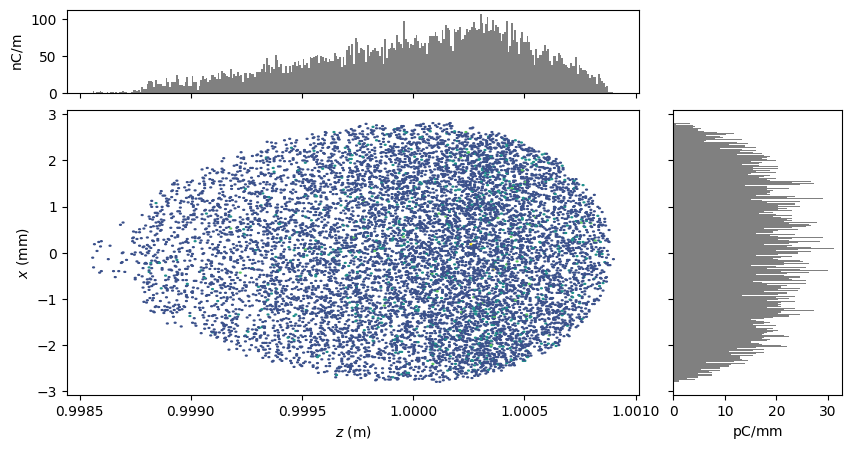

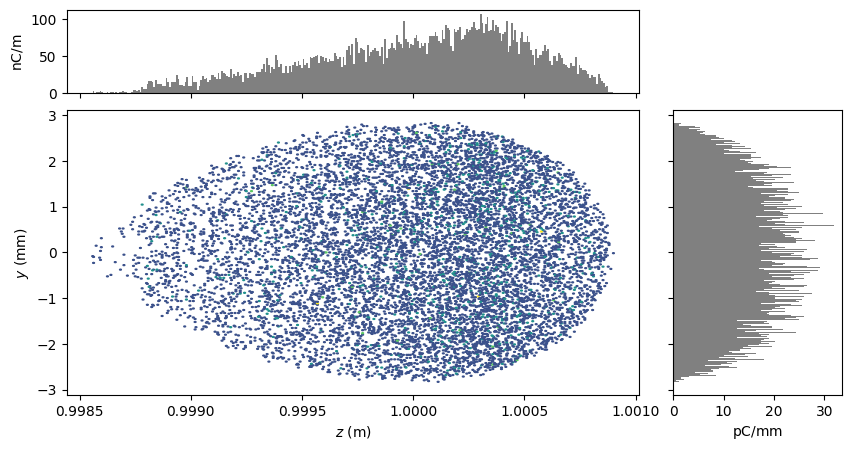

In [43]:
final_particle_group.plot('z', 'x', bins=300, figsize=(10, 5))
final_particle_group.plot('z', 'y', bins=300, figsize=(10, 5))

### Phase spaces

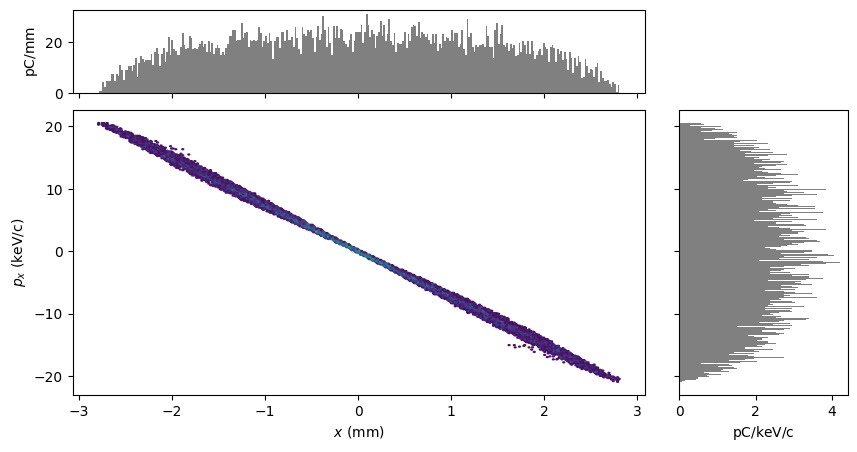

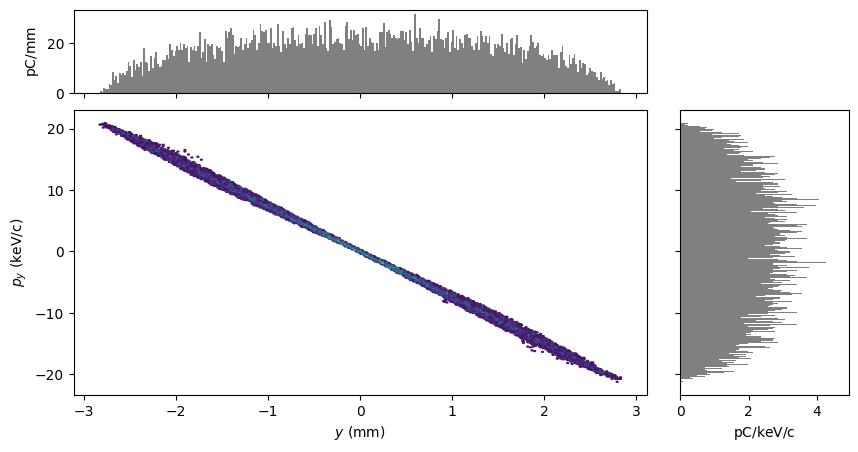

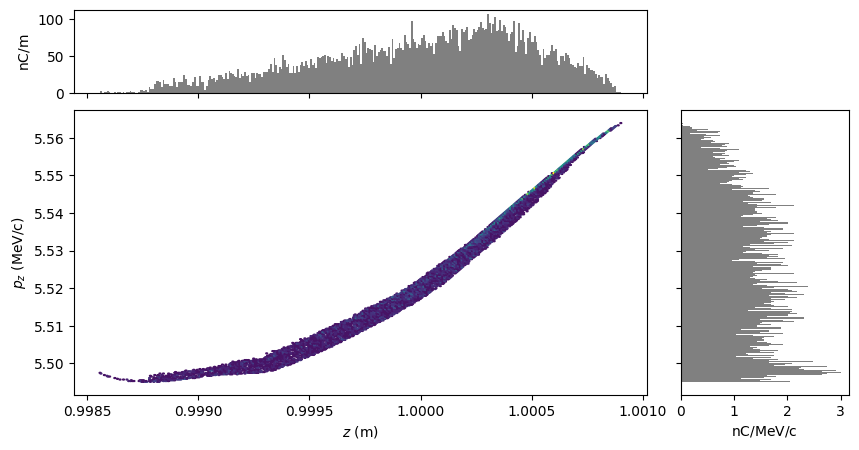

In [44]:
final_particle_group.plot('x', 'px', bins=300, figsize=(10, 5))
final_particle_group.plot('y', 'py', bins=300, figsize=(10, 5))
final_particle_group.plot('z', 'pz', bins=300, figsize=(10, 5))

### Emittance

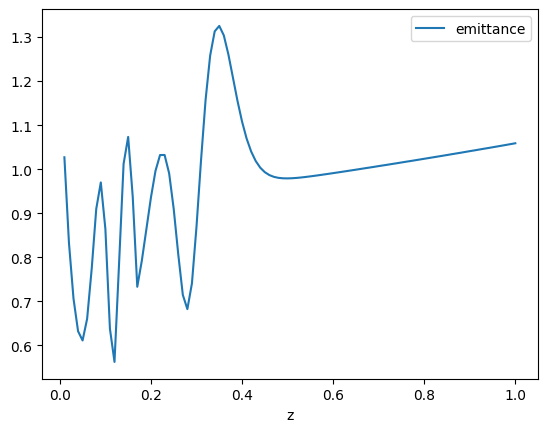

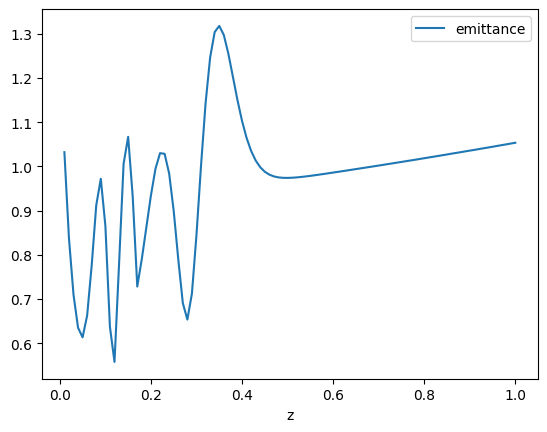

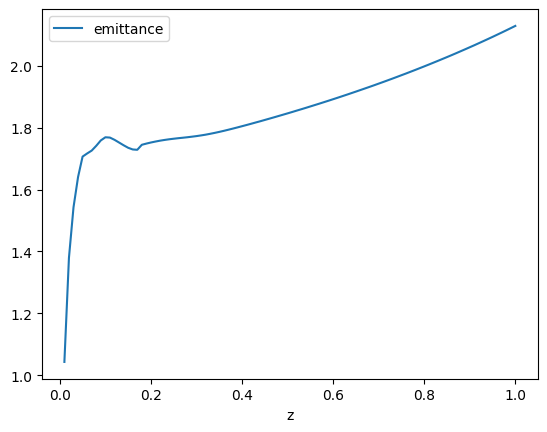

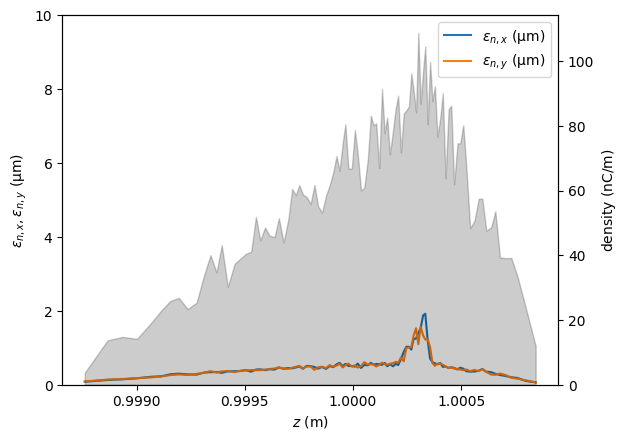

In [45]:
emit_x = pd.DataFrame(response['emittance_x'])
emit_y = pd.DataFrame(response['emittance_y'])
emit_z = pd.DataFrame(response['emittance_z'])
emit_x.plot(x='z', y='emittance')
emit_y.plot(x='z', y='emittance')
emit_z.plot(x='z', y='emittance')
final_particle_group.slice_plot('norm_emit_x', 'norm_emit_y', ylim=(0, 1e-5))

### Particle Trajectories

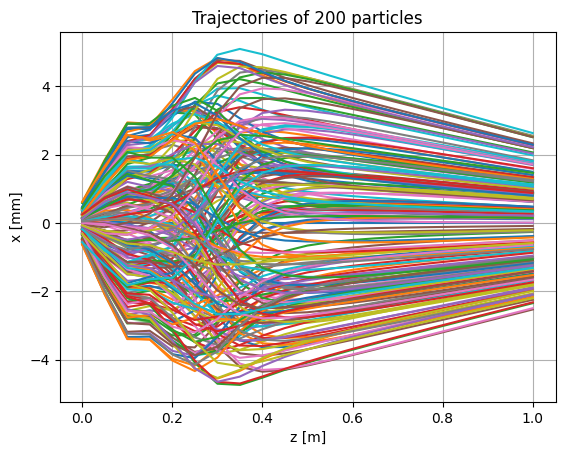

In [50]:
N = 50
plt.plot(
    [P[::N].z for P in  particle_groups],
    [P[::N].x*1e3 for P in  particle_groups]
)
plt.grid()
plt.xlabel("z [m]")
plt.ylabel("x [mm]")
plt.title(f"Trajectories of {particle_groups[0].n_particle//N} particles")
plt.show()

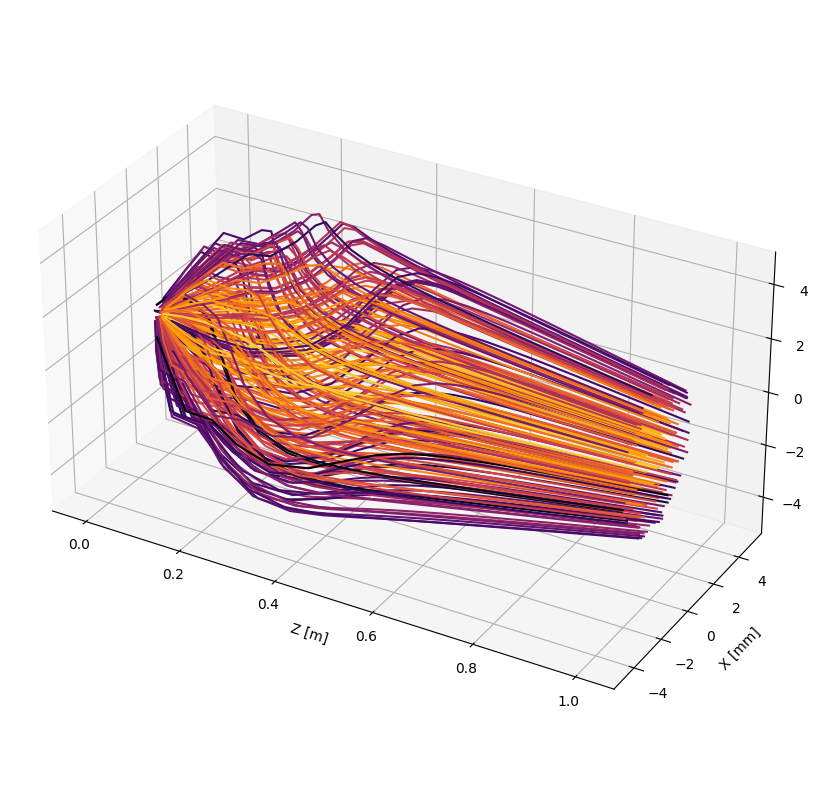

In [49]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
cmap = matplotlib.colormaps.get_cmap('inferno')

skip=1
X = np.array([P[::N].x for P in particle_groups]).T[::skip]
Y = np.array([P[::N].y for P in particle_groups]).T[::skip]
Z = np.array([P[::N].z for P in particle_groups]).T[::skip]

scale = np.hypot(X[:, 0], Y[:,0]).max()

# color by initial radius
for i in range(len(X)):
    color = cmap(1-np.hypot(X[i,0], Y[i,0])/scale)
    ax.plot(X[i]*1e3, Y[i]*1e3, Z[i], zdir='x', color=color)

ax.set_box_aspect((2,1,1))    
    
ax.set_xlabel('Z [m]')
ax.set_ylabel('X [mm]')
ax.set_zlabel('Y [mm]')

plt.show()

# Next steps

- Run simulation concurrently
- Agree on input parameters for first ML prototyping
- Sample data
- Train first forward models
- Write report for BMBF (until April 21st)
- investigate generation of different particle distribution / laser shapes, e.g. flat top combined with inverted parabola shape